In [2]:
import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Model Construction

In [2]:
class ResidualLayer(nn.Module):
#constructing the residual block layers for generator
#giving the same input and output size of channels
    def __init__(self, in_channels, out_channels):
        super(ResidualLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True, track_running_stats=True))
    def forward(self, x):
        return x + self.main(x)

In [3]:
class Discriminator(nn.Module):
#structure of discriminator for StarGAN
    def __init__(self, image_size=256, e_dim=7, repeat_num=6):
        super(Discriminator, self).__init__()
        #first layers expand the channel numbers from 3 into 64
        #followed by a leakyReLU as activation 
        layers = []
        layers.append(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = 64 #so we have 64 as the current dimention
        for i in range(1, repeat_num):
        #keep expanding the channel size 6 times
        #each iteration doubles the number of channel
        #they are also followed by LeakyReLU layers
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_out = int(image_size / np.power(2, repeat_num))
        #defining the output image size based on the 2 polinominal of repeat_number  
        self.main = nn.Sequential(*layers)
        #gathering all these layer sequentially as the main component of discriminator
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        #the discriminator gives 2 outputs
        #first one is for source discrimination for real/fake image
        # so the number of dimention is narrowed down to 1
        self.conv2 = nn.Conv2d(curr_dim, e_dim, kernel_size=kernel_out, bias=False)
        #the second output give the probability the disciminated image
        # is in which domain considering the number of emotional dimention e_dim
    def forward(self, x):
        h = self.main(x)#processingLayers
        out_src = self.conv1(h)# a probability distribution over the source given by D()
        out_cls = self.conv2(h)#domain classification
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

In [4]:
summary(Discriminator(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
         LeakyReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         524,544
         LeakyReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       2,097,664
         LeakyReLU-8          [-1, 512, 16, 16]               0
            Conv2d-9           [-1, 1024, 8, 8]       8,389,632
        LeakyReLU-10           [-1, 1024, 8, 8]               0
           Conv2d-11           [-1, 2048, 4, 4]      33,556,480
        LeakyReLU-12           [-1, 2048, 4, 4]               0
           Conv2d-13              [-1, 1, 4, 4]          18,432
           Conv2d-14              [-1, 

In [3]:
class Generator(nn.Module):
#generator stucture
    def __init__(self, e_dim=7, repeat_num=6):
        super(Generator, self).__init__()
        layers = []
        #similar to discriminator, initial image channel is expanded
        # into 64
        #however, the emotional layer is embedded along the channel dimention 
        # to direct the original image into the target domain
        layers.append(nn.Conv2d(3+e_dim, 64, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(64, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))
        curr_dim = 64#current dimention before downsampling
        for i in range(2):
            #decomposing the initial dimention of channel by a half for 2 times
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2
        # Residual layers.
        for i in range(repeat_num):#applying the residual layers 
            layers.append(ResidualLayer(in_channels=curr_dim, out_channels=curr_dim))
        for i in range(2):
            # Up-sampling the layers with corresponding reversed convolution with the downsampling layers
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2
        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        #return the original channel shape
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)
    def forward(self, x, c):#attached with a target label domain
        #embedding = self.embed(c).view(c.shape[0],1,256,256)
        c = c.view(c.size(0), c.size(1), 1, 1)
        #1*7*1*1 process the labels to make it matches with the tensor view of images 
        c = c.repeat(1, 1, x.size(2), x.size(3))
        # before concatenating the target label into
        x = torch.cat([x, c], dim=1)
        return self.main(x) 
    # the label is embedded before putting into main components of sequential layers 

# Data Loading

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()#load the available device

In [7]:
image_size = 256
batch_size = 16 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_All='C:/Users/Pro/Desktop/Grp_Project/URGENT!/JAFFE_LABEL'
#load the images from the folder file and preprocess it into the tensor form and normalization into mean value
folder_All = ImageFolder(DIR_All, transform=tt.Compose([tt.RandomHorizontalFlip(),tt.ToTensor(),tt.Normalize(*stats)]))
train_All = DataLoader(folder_All, batch_size, shuffle=True, num_workers=1)
#7 emotional domains are stored in 7 different folders representing their corresponding labels 
#(from 0 to 6 )

In [8]:
def denorm(img_tensors):
    #reverse normalization
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    #and show the package of images in the intial form
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

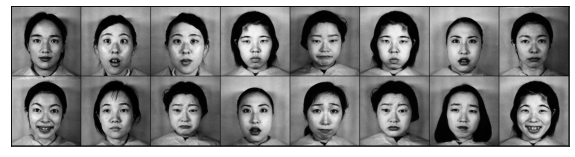

In [9]:
show_batch(train_All)

In [10]:
D = to_device(Discriminator(), device)
# inject the discriminator and generator into the device
G = to_device(Generator(), device)

In [11]:
data_loader = DeviceDataLoader(train_All,device)
#inject the data also into the device

In [12]:
import torch.optim as optim
#defining the optimization method for Discriminator and Generator
opt_disc = optim.Adam(D.parameters(), lr=1e-4,betas=(0.5,0.999))#momentum & beta2
opt_gen = optim.Adam(G.parameters(), lr=1e-4,betas=(0.5,0.999))

In [13]:
cls_loss=nn.CrossEntropyLoss()#loss for label optimization
L1_loss = nn.L1Loss()#reconstruction loss

# Materials

In [14]:
def label2onehot(labels, dim):
    #convert the initial labels from defined by different folder into one-hot vector
    #containing only 1s for the target domain and match with the size of the batch
    batch_size = labels.size(0)
    out = torch.zeros(batch_size, dim)
    out[np.arange(batch_size), labels.long()] = 1
    return out

In [21]:
label2onehot(torch.ones(3)*2, 7)

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])

In [15]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,inputs=x,grad_outputs=weight,retain_graph=True,create_graph=True,only_inputs=True)[0]
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

# Training

In [38]:
loss = {}

In [57]:
num_epochs = 10
for epoch in range(num_epochs):
    for i, (x_real, label_org) in enumerate(data_loader):
        rand_idx = torch.randperm(label_org.size(0))
        #randomly create target label corresponding to the number of batch size
        label_trg = label_org[rand_idx]
        
        c_org = label2onehot(label_org, 7)
        #convert the raw labels of original and target side
        #into one hot vector
        c_trg = label2onehot(label_trg, 7)
        #inject these parameters into device
        x_real = x_real.to(device)           # Input images.
        c_org = c_org.to(device)             # Original domain labels.
        c_trg = c_trg.to(device)             # Target domain labels.
        label_org = label_org.to(device)     # Labels for computing classification loss.
        label_trg = label_trg.to(device)     # Labels for computing classification loss.
        ##TrainDiscriminator:
        #loss with real images
        out_src, out_cls = D(x_real)
        #putting the real images into Discriminator
        d_loss_real = - torch.mean(out_src)
        #defining the mean as the probability for the reality of the input image
        d_loss_cls = cls_loss(out_cls, label_org)
        #in parallel, the correct label is 
        #ensured and optimized by the classificationloss
        # with the later output of D and the original label

        # Compute loss with fake images.
        x_fake = G(x_real, c_trg)
        #injecting the fake images into the discriminator to train it 
        #the ability to distinguish fake images and fake target labels
        out_src, out_cls = D(x_fake)
        d_loss_fake = torch.mean(out_src)

        # Compute loss for gradient penalty.
        alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
        x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
        out_src, _ = D(x_hat)
        d_loss_gp = gradient_penalty(out_src, x_hat)

        # Backward and optimize.
        d_loss = d_loss_real + d_loss_fake + d_loss_cls + 10 * d_loss_gp
        #sum up all loss and use Adam optimizor to backpropagate for updating weight
        opt_disc.zero_grad()
        d_loss.backward()
        opt_disc.step()
        #save the loss data
        loss['D/loss_real'] = d_loss_real.item()
        loss['D/loss_fake'] = d_loss_fake.item()
        loss['D/loss_cls'] = d_loss_cls.item()
        #loss['D/loss_gp'] = d_loss_gp.item()
        
        if (i+1) % 5 == 0:
            #generator is trained for each 5 times of the discriminator
            # Original-to-target domain.
            x_fake = G(x_real, c_trg)
            #generate fake images from real one embedding the target labels
            out_src, out_cls = D(x_fake)
            #using the discrimintor to give 2 evaluations on it
            g_loss_fake = - torch.mean(out_src)
            #loss for generating fake images
            g_loss_cls = cls_loss(out_cls, label_trg)
            #loss for the correct target label

            # Target-to-original domain.
            x_reconst = G(x_fake, c_org)
            #to retain the important content of the original images
            #the generated images is generated back into the original labeled domain
            g_loss_rec = L1_loss(x_reconst,x_real)
            #it is improved by using the MSE loss to make the reconstructed image 
            #comes close to the original one
            #torch.mean(torch.abs(x_real - x_reconst))

            # Backward and optimize.
            g_loss = g_loss_fake + 10 * g_loss_rec + g_loss_cls
            #gather all of them to train and backpropagate
            opt_gen.zero_grad()
            g_loss.backward()
            opt_gen.step()

            # Logging.
            loss['G/loss_fake'] = g_loss_fake.item()
            loss['G/loss_rec'] = g_loss_rec.item()
            loss['G/loss_cls'] = g_loss_cls.item()

    if epoch%2==0:#save the image to check the process for each 2 epoch
        save_image(torch.cat((x_real,x_fake), 0)*0.5+0.5,f"saved_images_{epoch}.png")
        #save_image(fake_cow*0.5+0.5,f"saved_images/cow_{i}.png")
#torch.save(D.state_dict(), os.path.join('weight', 'D.pkl'))
#torch.save(G.state_dict(), os.path.join('weight', 'G.pkl'))

In [62]:
save_image(torch.cat((x_real,x_fake), 0)*0.5+0.5,f"saved_images_{epoch}.png")

In [64]:
torch.save(G, 'GeneratorEmotions.pt')
torch.save(D, 'DiscriminatorEmotions.pt')
torch.save(loss, 'LossData.pt')

In [37]:
print(loss)

{'D/loss_real': -22.537174224853516, 'D/loss_fake': 9.722763061523438, 'D/loss_cls': 0.4785013198852539, 'D/loss_gp': 0.25776922702789307, 'G/loss_fake': -3.362622022628784, 'G/loss_rec': 0.15771552920341492, 'G/loss_cls': 2.1057400703430176}


In [38]:
model = torch.load('GeneratorEmotions.pt')
model.eval()

Generator(
  (main): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualLayer(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd